<a href="https://colab.research.google.com/github/SIDIBEMoussa/Image-segmentation-using-U-Net_/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch > lib
!pip install -U git+https://github.com/albumentations-team/albumentations  > lib
!pip install --upgrade opencv-contrib-python > lib

  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pokcxw5f


In [ ]:
! pip install opencv-python > lib

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 12.28 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
! mkdir train

! unzip train.zip -d train

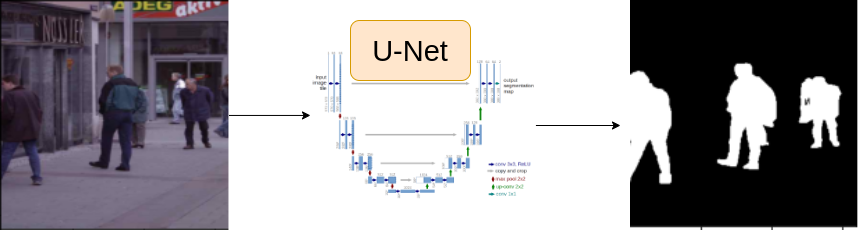

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [ ]:
import cv2
print(cv2.__version__)

4.7.0


# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"

DATA_DIR = "/content/"

DEVICE = "cuda"
LR = 0.003
EPOCHS = 25

IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [ ]:
df_image = pd.read_csv(CSV_FILE)

df_image.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df_image.iloc[21]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.


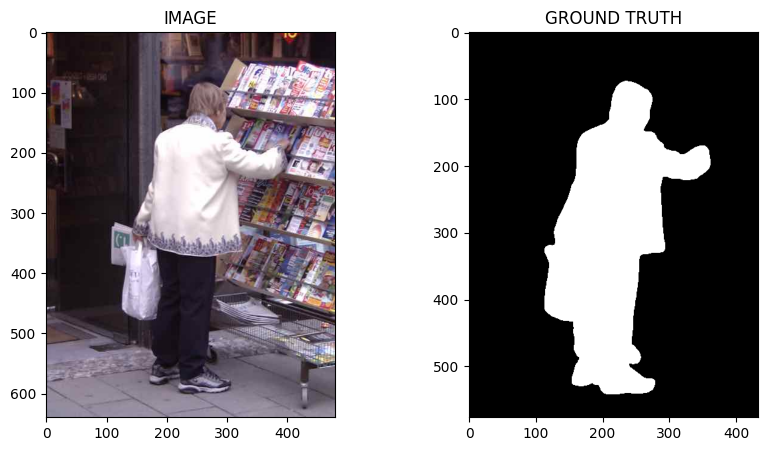

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df_image, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():

  return A.Compose([
          A.Resize(IMAGE_SIZE, IMAGE_SIZE),
          A.HorizontalFlip( p = 0.5 ),
          A.VerticalFlip( p = 0.5 )
      ],is_check_shapes=False)

def get_valid_augs():

  return A.Compose([
          A.Resize(IMAGE_SIZE, IMAGE_SIZE)
      ],is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):

        self.df = df
        self.augmentations = augmentations

    def __len__(self):

        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w,c)


        mask = np.expand_dims(mask, axis =-1)

        if self.augmentations:

            data = self.augmentations(image = image, mask = mask)

            image = data["image"]
            mask = data["mask"]

          #(h,w,c) ---> (c,w,h)

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image =torch.round(torch.Tensor(image)/255.0)
        mask = torch.round(torch.Tensor(mask)/255.0)

        return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())

validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


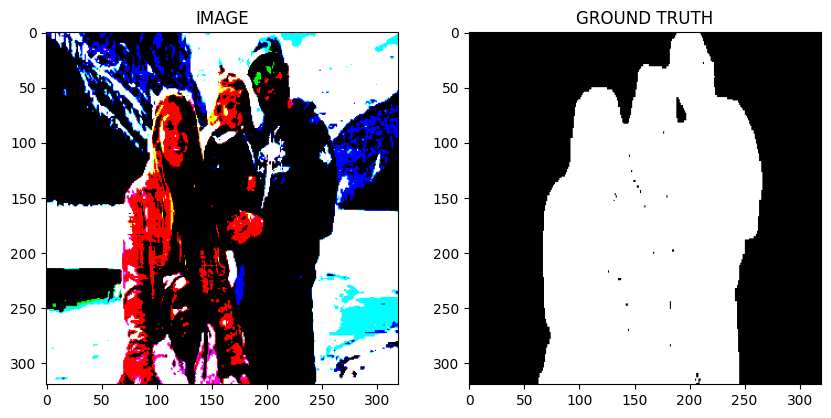

In [ ]:
idx = 2

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE, shuffle = True)

In [ ]:
print(f"Total no. batches in trainloader: {len(trainloader)}")

print(f"Total no. batches in validloader: {len(validloader)}")

Total no. batches in trainloader: 15
Total no. batches in validloader: 4


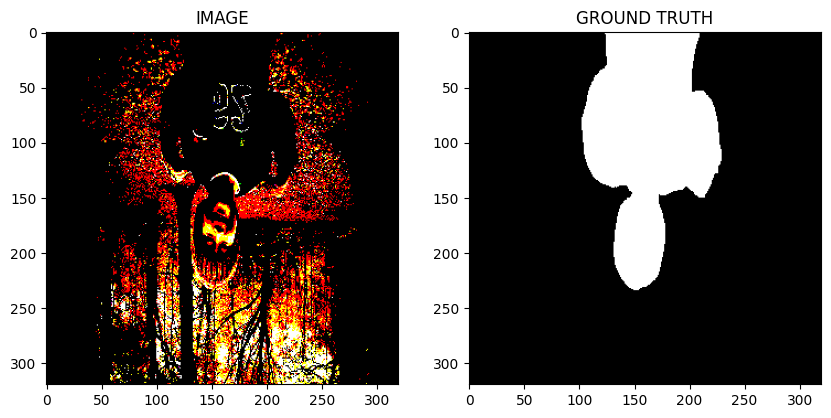

In [ ]:
idx = 21
image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

    def __init__(self):

        super(SegmentationModel,self).__init__()
        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )
    def forward(self, images, masks = None):

        logits = self.arc(images)

        if masks != None :

            loss1 = DiceLoss(mode = "binary")(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)

            return logits, loss1 + loss2

        return logits


In [ ]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:02<00:00, 9.94MB/s]


# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(dataloader, model, optimizer):

    model.train()
    total_loss = 0.0

    for images, masks in tqdm(dataloader):

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss

        return total_loss/len(dataloader)

In [ ]:
def eval_fn(dataloader, model):

    model.eval()
    total_loss = 0.0
    with torch.no_grad():

        for images, masks in tqdm(dataloader):

            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss

        return total_loss/len(dataloader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.inf

for i in range(EPOCHS):

    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:

        torch.save(model.state_dict(), "best_model.pt")

        print("MODEL SAVED")
        best_valid_loss = valid_loss
        print(f"Epoch:{i+1} Train_loss : {train_loss:.4f} Valid_loss: {valid_loss:.4f}")


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


MODEL SAVED
Epoch:1 Train_loss : 0.0385 Valid_loss: 0.8558


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


MODEL SAVED
Epoch:10 Train_loss : 0.0358 Valid_loss: 0.8081


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


MODEL SAVED
Epoch:11 Train_loss : 0.0347 Valid_loss: 0.6662


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


MODEL SAVED
Epoch:12 Train_loss : 0.0363 Valid_loss: 0.5614


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


MODEL SAVED
Epoch:13 Train_loss : 0.0412 Valid_loss: 0.5456


100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


MODEL SAVED
Epoch:14 Train_loss : 0.0320 Valid_loss: 0.5191


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


MODEL SAVED
Epoch:17 Train_loss : 0.0414 Valid_loss: 0.5115


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


MODEL SAVED
Epoch:20 Train_loss : 0.0399 Valid_loss: 0.5014


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


# Task 9 : Inference